In [7]:
# %%capture
# %pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [8]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl

Please replace `YOUR_API_KEY` with the assigned API key string. Note that it should be without quotes.

For example, if the assigned API Key is `abcd1234`, you can do the following

```python
%env ROCKFISH_API_KEY=abcd1234
conn = rf.Connection.from_env()
```

If you do not have API Key, please reach out to support@rockfish.ai.


In [9]:
%env ROCKFISH_API_KEY=YOUR_API_KEY
conn = rf.Connection.from_env()

In [10]:
# download our example of tabular data: fall_detection.csv
!wget --no-clobber https://docs.rockfish.ai/tutorials/fall_detection.csv

I0000 00:00:1738877938.363275 19607011 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


File ‘fall_detection.csv’ already there; not retrieving.



In [11]:
dataset = rf.Dataset.from_csv("fall_detection", "fall_detection.csv")
dataset.to_pandas()

,Age range of patient,Sex,Involvement of medication associated with fall risk,Whether a fall prevention protocol was implemented,Reason for incident,Whether a restraint prescription was given,Whether a physical therapy prescription was given,BBS Score,Body Temperature,Heart Rate,...,Chronic Heart Failure,Stroke,Frozen shoulder,Osteoarthritis of hip,Cerebellar Ataxia,Hemiparesis,GB Syndrome,Fall risk level,Ischemic Heart Disease,Cervical sopondylitis
0,60<70,M,Yes,Yes,Slip,No,Yes,41,97,80,...,No,No,No,No,No,No,No,High,No,No
1,30<40,F,Yes,Yes,Loss of balance,No,No,41,96,78,...,No,No,No,No,No,No,No,High,No,No
2,60<70,M,Yes,Yes,Mental confusion,No,Yes,43,98,81,...,No,No,No,No,No,No,No,High,No,No
3,80<90,M,Yes,Yes,Mental confusion,No,Yes,40,99,82,...,No,No,No,No,No,No,No,High,No,No
4,60<70,M,Yes,Yes,Loss of balance,No,Yes,40,96,90,...,No,No,No,No,No,No,No,High,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,50<60,M,No,No,Muscle weakness,No,No,44,97,67,...,No,No,No,No,No,No,No,Moderate,No,No
2578,80<90,F,No,No,Hypotension,No,No,43,97,96,...,No,No,No,No,No,No,No,Moderate,No,No
2579,30<40,F,No,No,Muscle weakness,No,No,43,96,76,...,No,No,No,No,No,No,No,Moderate,No,No
2580,60<70,M,No,Yes,Loss of balance,No,No,44,99,101,...,No,No,No,No,No,No,No,Moderate,No,No


In [28]:
categorical_fields = (
    dataset.to_pandas().select_dtypes(include=["object"]).columns
)
continuous_fields = [
    field
    for field in dataset.table.column_names
    if field not in categorical_fields
]
config = ra.TrainTabGAN.Config(
    tabular_gan=ra.TrainTabGAN.TrainConfig(epochs=100),
    encoder=ra.TrainTabGAN.DatasetConfig(
        metadata=[
            ra.TrainTabGAN.FieldConfig(field=field, type="categorical")
            for field in continuous_fields
        ]
        + [
            ra.TrainTabGAN.FieldConfig(field=field, type="categorical")
            for field in categorical_fields
        ],
    ),
)
train = ra.TrainTabGAN(config)

In [30]:
builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)

print(f"Workflow: {workflow.id()}")

Workflow: 3jdlbsNnAm5UtSQRAH4zv3


In [31]:
async for log in workflow.logs():
    print(log)

2025-02-06T21:47:50Z dataset-load: INFO Downloading dataset '41tnsu0YO9d3EBT5Iv9NqO'
2025-02-06T21:47:50Z dataset-load: INFO Downloaded dataset '41tnsu0YO9d3EBT5Iv9NqO' with 2582 rows
2025-02-06T21:47:50Z train-tab-gan: INFO Starting training...
2025-02-06T21:47:51Z train-tab-gan: INFO Epoch 1 completed
2025-02-06T21:47:51Z train-tab-gan: INFO Epoch 2 completed
2025-02-06T21:47:52Z train-tab-gan: INFO Epoch 3 completed
2025-02-06T21:47:52Z train-tab-gan: INFO Epoch 4 completed
2025-02-06T21:47:52Z train-tab-gan: INFO Epoch 5 completed
2025-02-06T21:47:53Z train-tab-gan: INFO Epoch 6 completed
2025-02-06T21:47:53Z train-tab-gan: INFO Epoch 7 completed
2025-02-06T21:47:53Z train-tab-gan: INFO Epoch 8 completed
2025-02-06T21:47:54Z train-tab-gan: INFO Epoch 9 completed
2025-02-06T21:47:54Z train-tab-gan: INFO Epoch 10 completed
2025-02-06T21:47:54Z train-tab-gan: INFO Epoch 11 completed
2025-02-06T21:47:55Z train-tab-gan: INFO Epoch 12 completed
2025-02-06T21:47:55Z train-tab-gan: INFO Ep

In [32]:
model = await workflow.models().nth(0)
model

Model(id='16676825-e4d4-11ef-a569-c275ba02a948', labels={'workflow_id': '3jdlbsNnAm5UtSQRAH4zv3'}, create_time=datetime.datetime(2025, 2, 6, 21, 48, 23, tzinfo=datetime.timezone.utc), size_bytes=11162624)

In [33]:
generate = ra.GenerateTabGAN(tabular_gan=ra.GenerateTabGAN.GenerateConfig())
save = ra.DatasetSave(name="synthetic")
target = ra.SessionTarget(target=30_000)
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model, target])
builder.add_action(target, parents=[generate])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 2XIKCBl7PxmuOL5UjdQ23o


In [34]:
async for log in workflow.logs():
    print(log)

2025-02-06T21:52:55Z generate-tab-gan: INFO Generating 23000 records
2025-02-06T21:52:56Z session-target: INFO new=23000 total=23000 needs=7000
2025-02-06T21:52:57Z dataset-save: INFO Saved dataset '6CN7BhFTdwXTmLrZu00aXW' with 23000 rows
2025-02-06T21:52:57Z generate-tab-gan: INFO Generating 23000 records
2025-02-06T21:52:58Z session-target: INFO new=23000 total=46000 needs=-16000


In [35]:
syn = await workflow.datasets().concat(conn)
syn.to_pandas()

,Age range of patient,Sex,Involvement of medication associated with fall risk,Whether a fall prevention protocol was implemented,Reason for incident,Whether a restraint prescription was given,Whether a physical therapy prescription was given,BBS Score,Body Temperature,Heart Rate,...,Chronic Heart Failure,Stroke,Frozen shoulder,Osteoarthritis of hip,Cerebellar Ataxia,Hemiparesis,GB Syndrome,Fall risk level,Ischemic Heart Disease,Cervical sopondylitis
0,< 1,M,No,Yes,Hypotension,No,Yes,44,98,72,...,No,No,No,No,No,No,No,High,No,No
1,60<70,F,No,No,Slip,No,No,39,97,81,...,No,No,No,No,No,No,No,Moderate,No,No
2,60<70,F,No,Yes,Muscle weakness,No,Yes,42,97,75,...,No,No,No,No,No,No,No,High,No,No
3,40<50,F,Yes,No,Hypotension,No,No,42,97,67,...,No,No,No,No,No,No,No,High,No,No
4,40<50,F,Yes,Yes,Loss of balance,No,No,39,97,75,...,No,No,No,No,No,No,No,Moderate,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,70<80,M,Yes,Yes,Trip,No,Yes,43,97,81,...,No,No,No,No,No,No,No,High,Yes,No
29996,50<60,F,Yes,Yes,Loss of balance,No,No,37,99,70,...,No,No,No,No,No,No,No,High,No,No
29997,70<80,M,Yes,Yes,Hypotension,No,Yes,40,97,92,...,No,No,Yes,No,No,No,No,High,Yes,No
29998,50<60,F,No,No,Muscle weakness,No,No,44,96,92,...,No,No,No,No,No,No,No,High,No,No


### Evaluation


**1. categorical columns**


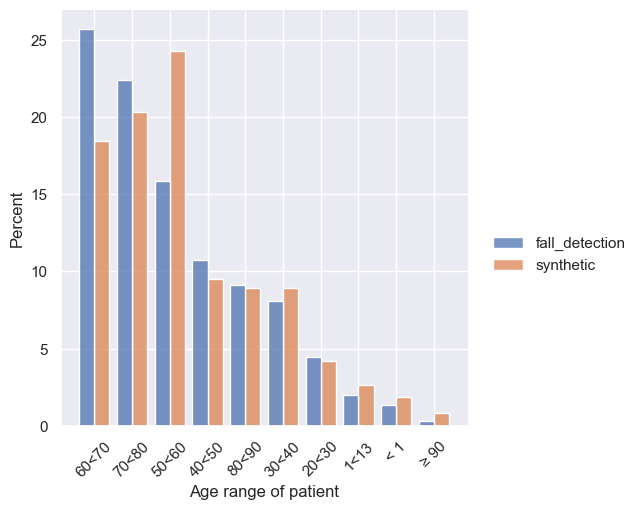

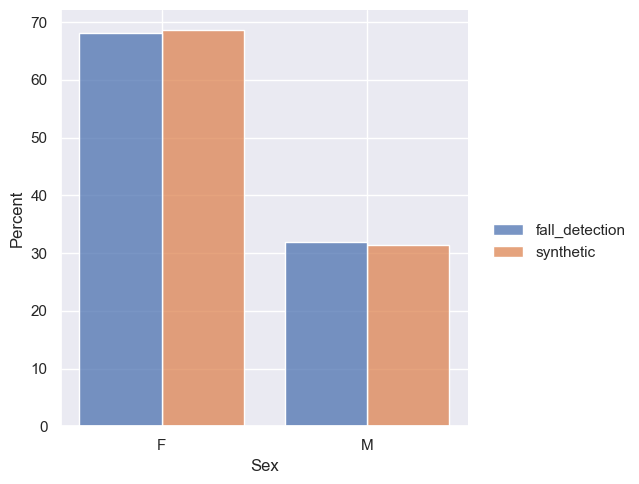

In [36]:
for col in ["Age range of patient", "Sex"]:
    source_agg = rf.metrics.count_all(dataset, col, nlargest=10)
    syn_agg = rf.metrics.count_all(syn, col, nlargest=10)
    rl.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")

**2. numerical columns**


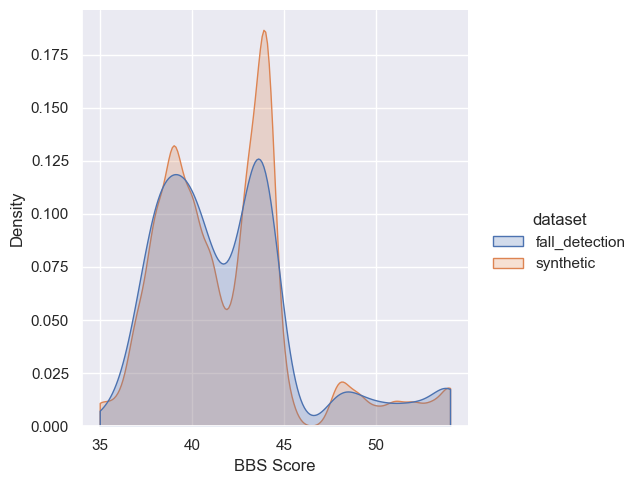

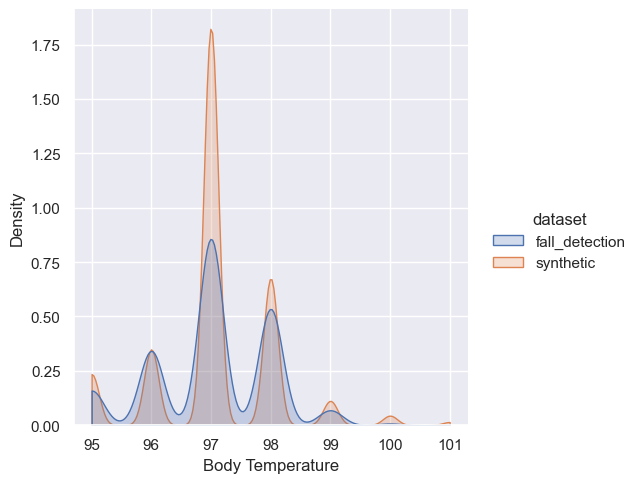

In [37]:
for col in ["BBS Score", "Body Temperature"]:
    rl.vis.plot_kde([dataset, syn], col)

**3. correlation between numerical columns**


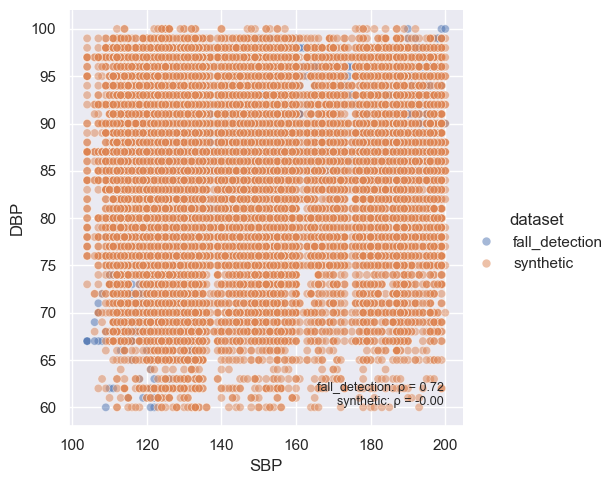

In [38]:
col1 = "SBP"
col2 = "DBP"
rl.vis.plot_correlation([dataset, syn], col1, col2, alpha=0.5)

**4. correlation heatmap between several numerical columns**


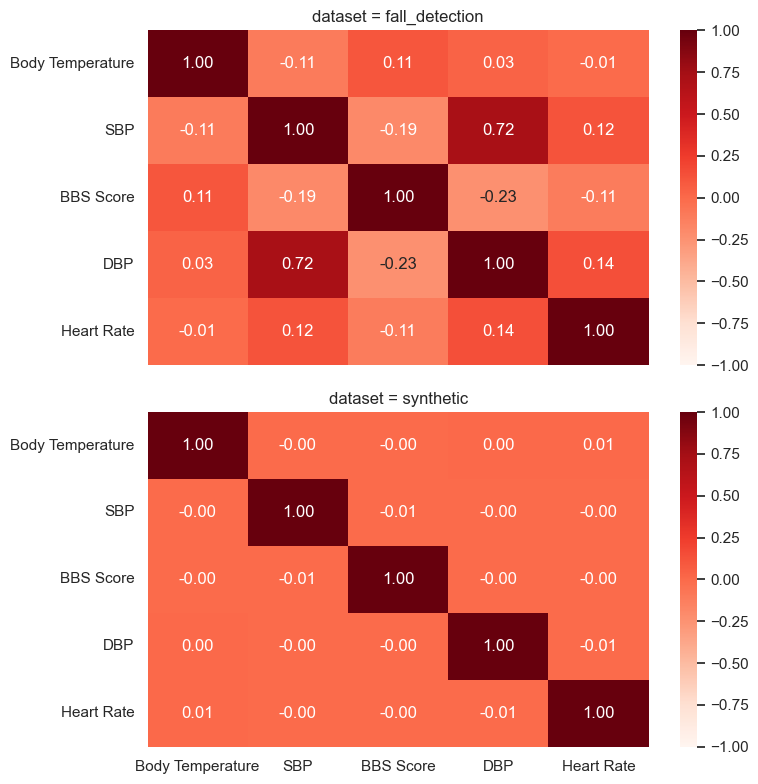

In [39]:
n_cols = ["Body Temperature", "SBP", "BBS Score", "DBP", "Heart Rate"]
rl.vis.plot_correlation_heatmap([dataset, syn], n_cols, annot=True, fmt=".2f")